# Working with ECOSTRESS Evapotranspiration Data
### This tutorial demonstrates how to work with the ECOSTRESS Evapotranspiration PT-JPL Daily L3 Global 70m Version 1 ([ECO3ETPTJPL.001](https://doi.org/10.5067/ECOSTRESS/ECO3ETPTJPL.001)) data product in Python.
The Land Processes Distributed Active Archive Center (LP DAAC) distributes the Ecosystem Spaceborne Thermal Radiometer Experiment on Space Station ([ECOSTRESS](https://ecostress.jpl.nasa.gov/)) data products. The ECOSTRESS mission is tasked with measuring the temperature of plants to  better understand how much water plants need and how they respond to stress.  ECOSTRESS products are archived and distributed in the HDF5 file format as swath-based products.

In this tutorial, you will use Python to perform a swath to grid conversion to project the swath data on to a grid with a defined coordinate reference system (CRS), compare ECOSTRESS data with ground-based AmeriFlux flux tower observations, and export science dataset (SDS) layers as GeoTIFF files that can be loaded into a GIS and/or Remote Sensing software program. 
***
### Example: Converting a swath ECO3ETPTJPL.001 HDF5 file into a GeoTIFF with a defined CRS and comparing ECOSTRESS Evapotranspiration (ET) with ground-based ET observations from an AmeriFlux flux tower location in California.           
#### Data Used in the Example:  
- Data Product: ECOSTRESS Evapotranspiration PT-JPL Daily L3 Global 70m Version 1 ([ECO3ETPTJPL.001](https://doi.org/10.5067/ECOSTRESS/ECO3ETPTJPL.001))  
     - Science Dataset (SDS) layers:  
        - ETinst     
        - ETinstUncertainty    
- Data Product: ECOSTRESS Geolocation Daily L1B Global 70m Version 1 ([ECO1BGEO.001](https://doi.org/10.5067/ECOSTRESS/ECO1BGEO.001))  
     - Science Dataset (SDS) layers:  
        - Latitude     
        - Longitude    
- Data Product: AmeriFlux Ground Observations for [Flux Tower US-CZ3](https://ameriflux.lbl.gov/sites/siteinfo/US-CZ3): Sierra Critical Zone, Sierra Transect, Sierran Mixed Conifer, P301
     - Variables:  
        - Latent Heat (W/m$^{2}$)     
***  
# Topics Covered:
1. **Getting Started**    
    1a. Import Packages    
    1b. Set Up the Working Environment      
    1c. Retrieve Files    
2. **Importing and Interpreting Data**    
    2a. Open an ECOSTRESS HDF5 File and Read File Metadata     
    2b. Subset SDS Layers   
3. **Performing Swath2grid Conversion**    
    3a. Import Geolocation File  
    3b. Define Projection and Output Grid  
    3c. Read SDS Metadata  
    3d. Perform K-D Tree Resampling  
    3e. Basic Image Processing  
4. **Exporting Results**    
    4a. Set Up a Dictionary  
    4b. Define CRS and Export as GeoTIFFs  
5. **Combining ECOSTRESS and AmeriFlux Tower Data**    
    5a. Loading Tables with Pandas  
    5b. Locate ECOSTRESS Pixel from Lat/Lon Coordinates  
6. **Visualizing Data**      
    6a. Create Colormap   
    6b. Plot ET Data  
    6c. Exporting an Image  
7. **Comparing Observations**      
    7a. Calculate Distribution of ECOSTRESS Data    
    7b. Visualize Ground Observations  
    7c. Combine ECOSTRESS and Ground Observations  

***
# Before Starting this Tutorial:  
#### If you are simply looking to batch process/perform the swath2grid conversion for ECOSTRESS files, be sure to check out the [ECOSTRESS Swath to Grid Conversion Script](https://git.earthdata.nasa.gov/projects/LPDUR/repos/ecostress_swath2grid/browse).

NOTE: This tutorial was developed specifically for the ECOSTRESS Evapotranspiration PT-JPL Level 3, Version 1 HDF5 files and will need to be adapted to work with other ECOSTRESS products.  
## Dependencies:  
*Disclaimer: This tutorial has been tested on Windows and MacOS using the specifications identified below.*    
+ #### Python Version 3.8  
  + `h5py`  
  + `pyproj`  
  + `matplotlib`  
  + `pandas`  
  + `pyresample`  
  + `pandas`    
  + `scipy`    
  + `gdal`     
  + `jupyter notebook`

- A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided.  
- The [Geospatial Data Abstraction Library](http://www.gdal.org/) (GDAL) is required.

---
# Procedures:     
## Getting Started:      
#### 1. This tutorial uses data from ECOSTRESS Version 1, including an ECO3ETPTJPL.001 (and accompanying ECO1BGEO.001) observation from August 05, 2018. You can download the files directly from the [LP DAAC Data Pool](https://e4ftl01.cr.usgs.gov/ECOSTRESS/) at:
  - [ECOSTRESS_L1B_GEO_00468_007_20180805T220314_0601_03.h5](https://e4ftl01.cr.usgs.gov/ECOSTRESS/ECO1BGEO.001/2018.08.05/ECOSTRESS_L1B_GEO_00468_007_20180805T220314_0601_03.h5)  
  - [ECOSTRESS_L3_ET_PT-JPL_00468_007_20180805T220314_0601_04.h5](https://e4ftl01.cr.usgs.gov/ECOSTRESS/ECO3ETPTJPL.001/2018.08.05/ECOSTRESS_L3_ET_PT-JPL_00468_007_20180805T220314_0601_04.h5)  
**A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided.**    

 - Ancillary Files Needed:  
    - The AmeriFlux Latent Heat data used in Section 4 can be downloaded via a [csv file](https://git.earthdata.nasa.gov/projects/LPDUR/repos/tutorial-ecostress/raw/tower_data.csv?at=refs%2Fheads%2Fmain).  

The `tower_data.csv` file will need to be downloaded into the same directory as the tutorial in order to execute the tutorial.      
#### 2.	Copy/clone/download the [ECOSTRESS Tutorial repo](https://git.earthdata.nasa.gov/rest/api/latest/projects/LPDUR/repos/tutorial-ecostress/archive?format=zip), or the desired tutorial from the LP DAAC Data User Resources Repository:   
 -  [Working with ECOSTRESS Evapotranspiration Data in Python Jupyter Notebook](https://git.earthdata.nasa.gov/projects/LPDUR/repos/tutorial-ecostress/browse/ECOSTRESS_Tutorial.ipynb)   
<div class="alert alert-block alert-warning" >
<b>NOTE:</b> This tutorial was developed specifically for the ECOSTRESS Evapotranspiration PT-JPL Level 3, Version 1 HDF5 files and will need to be adapted to work with other ECOSTRESS products. </div> 

***
<h1><center>1. Getting Started</center></h1>

***
## 1a. Import Packages 
#### Import the python packages required to complete this tutorial.

In [1]:
# Import packages
import warnings
warnings.filterwarnings('ignore')

import h5py
import os
from os.path import join
import pyproj
import numpy as np
import pandas as pd
import datetime
from dateutil import parser
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pyresample import geometry as geom
from pyresample import kd_tree as kdt
from osgeo import gdal, gdal_array, gdalconst, osr

# Set plots inside of the Jupyter Notebook
%matplotlib inline

***
## 1b. Set Up the Working Environment
#### The input directory is defined as the current working directory. Note that you will need to have the jupyter notebook and example data (.h5 and .csv) stored in this directory in order to execute the tutorial successfully.

In [2]:
# Current working directory will be set as the input directory
inDir =  "D:/Downloads/ecoworkshop/" #os.getcwd() + os.sep                                                     
print("input directory:\n{}".format(inDir))

# Set output directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + os.sep  
print("output directory:\n{}".format(outDir))

# Create output directory
if not os.path.exists(outDir): 
    os.makedirs(outDir)

input directory:
D:/Downloads/ecoworkshop/
output directory:
D:\Downloads\ecoworkshop\output\


#### Make sure that the ECOSTRESS .h5 data files, and Ameriflux ET data file (.csv) are located in the input directory printed above.

***
## 1c. Retrieve Files
#### Make sure that the ECO1BGEO and ECO3ETPTJPL .h5 files listed in the directions have been downloaded to the `inDir` defined above to follow along in the tutorial.

In [3]:
os.chdir(inDir)

In [4]:
# List directory contents and create lists of ECOSTRESS HDF5 files (GEO, ET)
geoList = [file for file in os.listdir() if file.endswith('.h5') and 'GEO' in file]
print("geolocation:\n{}".format("\n".join(geoList)))
ecoList = [file for file in os.listdir() if file.endswith('.h5') and 'GEO' not in file]
print("products:\n{}".format("\n".join(ecoList)))

geolocation:
ECOSTRESS_L1B_GEO_00468_007_20180805T220314_0601_03.h5
products:
ECOSTRESS_L3_ET_PT-JPL_00468_007_20180805T220314_0601_04.h5


#### The standard format  for ECOSTRESS filenames is as follows:
> **ECOSTRESS_L3_ET_PT-JPL**:     Product Type    
**00468**:      Orbit number; starting at start of mission, ascending equatorial crossing    
**007**:        Scene ID; starting at first scene of first orbit   
**20180805T220314**: Date and time of data start: YYYYMMDDThhmmss  
**0601**: Build ID of software that generated product, Major+Minor (2+2 digits)  
**04**: Product version number (2 digits)  

***
<h1><center>2. Importing and Interpreting Data</center></h1> 

***
## 2a. Open an ECOSTRESS HDF5 File
#### Read in an ECOSTRESS HDF5 file using the `h5py` package.

In [5]:
f = h5py.File(ecoList[0])             # Read in ECOSTRESS HDF5 file
ecoName = ecoList[0].split('.h5')[0]  # Keep original filename
print(ecoName)

ECOSTRESS_L3_ET_PT-JPL_00468_007_20180805T220314_0601_04


***
## 2b. Subset SDS Layers and read SDS Metadata
#### Identify and generate a list of all the SDS layers in the HDF5 file.

In [6]:
# Create a list of all SDS inside of the .h5 file
eco_objs = []
f.visit(eco_objs.append)
ecoSDS = [str(obj) for obj in eco_objs if isinstance(f[obj], h5py.Dataset)] 
for dataset in ecoSDS[0:10]: 
    print(dataset)

EVAPOTRANSPIRATION PT-JPL/ETcanopy
EVAPOTRANSPIRATION PT-JPL/ETdaily
EVAPOTRANSPIRATION PT-JPL/ETinst
EVAPOTRANSPIRATION PT-JPL/ETinstUncertainty
EVAPOTRANSPIRATION PT-JPL/ETinterception
EVAPOTRANSPIRATION PT-JPL/ETsoil
L3_ET_PT-JPL Metadata/AncillaryFileAerosolOpticalDepth
L3_ET_PT-JPL Metadata/AncillaryFileAirTemperatureNWP
L3_ET_PT-JPL Metadata/AncillaryFileAirTemperatureRS
L3_ET_PT-JPL Metadata/AncillaryFileAlbedo


#### Below, subset the SDS list to the two layers needed for comparison with the ground-based AmeriFlux data, `ETinst` and `ETinstUncertainty`.

In [7]:
# Subset list to ETinst and ETinstUncertainty
sds = ['ETinst', 'ETinstUncertainty']
ecoSDS = [dataset for dataset in ecoSDS if dataset.endswith(tuple(sds))]
for dataset in ecoSDS:
    print(dataset.split('/')[-1])

ETinst
ETinstUncertainty


***
<h1><center>3. Performing Swath2grid Conversion</center></h1>

#### Resample the native ECOSTRESS swath data to a grid with defined coordinate reference system (CRS).  
***
## 3a. Import Geolocation File
#### The `latitude` and `longitude` arrays from the ECO1BGEO product for the same ECOSTRESS orbit/scene ID are needed to perform the swath2grid conversion on the ECO3ETPT-JPL file. 

In [8]:
# Find the matching ECO1BGEO file from the file list
geo = [geoFile for geoFile in geoList if ecoList[0].split('ECOSTRESS_L3_ET_PT-JPL_')[-1].split('T')[0] in geoFile]
print(geo[0])
print(ecoList[0])

ECOSTRESS_L1B_GEO_00468_007_20180805T220314_0601_03.h5
ECOSTRESS_L3_ET_PT-JPL_00468_007_20180805T220314_0601_04.h5


#### Read in the ECO1BGEO file, search for the `latitude` and `longitude` SDS, and import into Python as arrays.

In [9]:
# Open Geo File
g = h5py.File(geo[0])
geo_objs = []
g.visit(geo_objs.append)

# Search for lat/lon SDS inside data file
latSD = [str(obj) for obj in geo_objs if isinstance(g[obj], h5py.Dataset) and '/latitude' in obj]
lonSD = [str(obj) for obj in geo_objs if isinstance(g[obj], h5py.Dataset) and '/longitude' in obj]

# Open SDS as arrays
lat = g[latSD[0]][()].astype(float)
lon = g[lonSD[0]][()].astype(float)

# Read the array dimensions
dims = lat.shape
print(dims)

(5632, 5400)


***
## 3b. Define Projection and Output Grid
#### The `latitude` and `longitude` arrays from the ECO1BGEO product for the same ECOSTRESS orbit/scene ID are needed to perform the swath2grid conversion on the ECO3ETPT-JPL file. 
#### The following sections use the [pyresample package](https://pyresample.readthedocs.io/en/stable/) to resample the ECOSTRESS swath dataset to a grid using nearest neighbor method. This process begins by defining the swath dimensions using the lat/lon arrays below.

In [10]:
# Set swath definition from lat/lon arrays
swathDef = geom.SwathDefinition(lons=lon, lats=lat)
swathDef.corners

[(-118.7239829569036, 34.221086430090274),
 (-121.86703190925778, 36.84456587689783),
 (-118.81973784761588, 39.05327678830593),
 (-115.71697211227038, 36.35603480980171)]

#### Define the coordinates in the middle of the swath, which are used to calculate an estimate of the output rows/columns for the gridded output. 

In [11]:
# Define the lat/lon for the middle of the swath
mid = [int(lat.shape[1] / 2) - 1, int(lat.shape[0] / 2) - 1]
midLat, midLon = lat[mid[0]][mid[1]], lon[mid[0]][mid[1]]
midLat, midLon

(36.63127602811011, -118.88736212064671)

#### Below, `pyproj.Proj` is used to perform a cartographic transformation by defining an Azimuthal Equidistant projection centered on the midpoint of the swath. Once the projection is defined, convert the lower left and upper right corners of the lat/lon arrays to a location (in meters) in the new projection. Lastly, measure the distance between the corners and divide by 70 (meters), the nominal pixel size that we are aiming for. Azimuthal Equidistant projection was chosen here based on the following characteristics of this projection:
- Units in meters (necessary for defining 70 m pixels)  
- Distances between all points are proportionally correct from center point
- Azimuth (direction) are correct from the center point

In [12]:
# Define AEQD projection centered at swath center
epsgConvert = pyproj.Proj("+proj=aeqd +lat_0={} +lon_0={}".format(midLat, midLon))

# Use info from AEQD projection bbox to calculate output cols/rows/pixel size
llLon, llLat = epsgConvert(np.min(lon), np.min(lat), inverse=False)
urLon, urLat = epsgConvert(np.max(lon), np.max(lat), inverse=False)
areaExtent = (llLon, llLat, urLon, urLat)
cols = int(round((areaExtent[2] - areaExtent[0]) / 70))  # 70 m pixel size
rows = int(round((areaExtent[3] - areaExtent[1]) / 70))

#### Use number of rows and columns generated above from the AEQD projection to set a representative number of rows and columns in the Geographic  area definition, which will then be translated to degrees below, then take the smaller of the two pixel dims to determine output size and ensure square pixels.

In [13]:
# Define Geographic projection
epsg, proj, pName = '4326', 'longlat', 'Geographic'

# Define bounding box of swath
llLon, llLat, urLon, urLat = np.min(lon), np.min(lat), np.max(lon), np.max(lat)
areaExtent = (llLon, llLat, urLon, urLat)

# Create area definition with estimated number of columns and rows
projDict = pyproj.CRS("epsg:4326")
areaDef = geom.AreaDefinition(epsg, pName, proj, projDict, cols, rows, areaExtent)

#### Below, square the pixels by setting the pixel size to the smaller of the x any y values output by the `AreaDefinition`, then use the pixel size to recalculate the number of output cols/rows.

In [14]:
# Square pixels and calculate output cols/rows
ps = np.min([areaDef.pixel_size_x, areaDef.pixel_size_y])
cols = int(round((areaExtent[2] - areaExtent[0]) / ps))
rows = int(round((areaExtent[3] - areaExtent[1]) / ps))

# Set up a new Geographic area definition with the refined cols/rows
areaDef = geom.AreaDefinition(epsg, pName, proj, projDict, cols, rows, areaExtent)

####  Below, use `pyresample kd_tree`'s [get_neighbour_info](https://pyresample.readthedocs.io/en/latest/swath.html#resampling-from-neighbour-info) to create arrays with information on the nearest neighbor to each grid point. 
#### This is the most computationally heavy task in the swath2grid conversion and using `get_neighbour_info` speeds up the process if you plan to resample multiple SDS within an ECOSTRESS product (compute once instead of for every SDS). 

In [15]:
# Get arrays with information about the nearest neighbor to each grid point 
index, outdex, indexArr, distArr = kdt.get_neighbour_info(swathDef, areaDef, 210, neighbours=1)

#### Above, the function is comparing the swath and area definitions to locate the nearest neighbor (neighbours=1). 210 is the `radius_of_influence`, or the radius used to search for the nearest neighboring pixel in the swath (in meters). 

***
## 3c. Read SDS Metadata
#### List the attributes for the `ETinst` layer, which can then be used to define the fill value and scale factor. 

In [16]:
# Read in ETinst and print out SDS attributes
s = ecoSDS[0]
ecoSD = f[s][()]
for attr in f[s].attrs:
    if type(f[s].attrs[attr]) == np.ndarray:
        print(f'{attr} = {f[s].attrs[attr][0]}')
    else:
        print(f'{attr} = {f[s].attrs[attr].decode("utf-8")}')

_FillValue = nan
add_offset = 0.0
long_name = Instantaneous Latent Heat Flux
scale_factor = 1.0
units = W/m^2
valid_max = 2000.0
valid_min = 0.0


#### Extract the scale factor, add offset and fill value from the SDS metadata.

In [17]:
f[s].attrs['_FillValue'][0]

nan

In [18]:
# Read SDS attributes and define fill value, add offset, and scale factor if available
try:
    fv = int(f[s].attrs['_FillValue'])
except KeyError:
    fv = None
except ValueError:
    fv = f[s].attrs['_FillValue'][0]
try:
    sf = f[s].attrs['_Scale'][0]
except:
    sf = 1
try:
    add_off = f[s].attrs['_Offset'][0]
except:
    add_off = 0
try:
    units = f[s].attrs['units'].decode("utf-8")
except:
    units = 'none'

***
## 3d. Perform K-D Tree Resampling
#### Remember that the resampling has been split into two steps. In section 3b. arrays containing the nearest neighbor to each grid point were created. The second step is to use those arrays to retrieve a resampled result. 

In [19]:
# Perform K-D Tree nearest neighbor resampling (swath 2 grid conversion)
ETgeo = kdt.get_sample_from_neighbour_info('nn', areaDef.shape, ecoSD, index, outdex, indexArr, fill_value=None)

#### Above, resample the swath `ecoSD` array using nearest neighbor (already calculated in section 3b. and defined above as the `index`, `outdex`, and `indexArr`), and also set the fill value that was defined in section 3c. 
#### Below, define the geotransform for the output (upper left x, horizontal pixel size, rotation, upper left y, rotation, vertical pixel size).

In [20]:
# Define the geotransform 
gt = [areaDef.area_extent[0], ps, 0, areaDef.area_extent[3], 0, -ps]
gt

[-121.86703190925778,
 0.0006302582963630697,
 0,
 39.05327678830593,
 0,
 -0.0006302582963630697]

***
## 3e. Basic Image Processing
#### Apply the scale factor and add offset and set the fill value defined in the previous section on the resampled data.

In [21]:
ETgeo = ETgeo * sf + add_off            # Apply Scale Factor and Add Offset
ETgeo[ETgeo == fv * sf + add_off] = fv  # Set Fill Value

#### Rerun steps 3c - 3e for `ETinstUncertainty`.

In [22]:
s = ecoSDS[1]
ecoSD = f[s][()]
try:
    fv = int(f[s].attrs['_FillValue'])
except KeyError:
    fv = None
except ValueError:
    fv = f[s].attrs['_FillValue'][0]
try:
    sf = f[s].attrs['_Scale'][0]
except:
    sf = 1
try:
    add_off = f[s].attrs['_Offset'][0]
except:
    add_off = 0
UNgeo = kdt.get_sample_from_neighbour_info('nn', areaDef.shape, ecoSD, index, outdex, indexArr, fill_value=None)
UNgeo = UNgeo * sf + add_off
UNgeo[UNgeo == fv * sf + add_off] = fv

***
<h1><center>4. Exporting Results</center></h1>

***
## 4a. Set Up a Dictionary
#### In this section, create a dictionary containing each of the arrays that will be exported as GeoTIFFs.

In [23]:
# Set up dictionary of arrays to export
outFiles = {'ETinst': ETgeo, 'ETinstUncertainty': UNgeo}

***
## 4b. Define CRS and Export as GeoTIFFs
#### Now that the data have been imported and resampled into a gridded raster array, export the results as GeoTIFFs using a `for` loop in this section.

In [24]:
fv = np.nan

In [25]:
# Loop through each item in dictionary created above
for file in outFiles:
    
    # Set up output name
    outName = join(outDir, '{}_{}.tif'.format(ecoName, file))
    print("output file:\n{}\n".format(outName))
    
    # Get driver, specify dimensions, define and set output geotransform
    height, width = outFiles[file].shape
    driv = gdal.GetDriverByName('GTiff')
    dataType = gdal_array.NumericTypeCodeToGDALTypeCode(outFiles[file].dtype)
    d = driv.Create(outName, width, height, 1, dataType)
    d.SetGeoTransform(gt)
        
    # Create and set output projection, write output array data
    # Define target SRS
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(int(epsg))
    d.SetProjection(srs.ExportToWkt())
    srs.ExportToWkt()
    
    # Write array to band
    band = d.GetRasterBand(1)
    band.WriteArray(outFiles[file])
    
    # Define fill value if it exists, if not, set to mask fill value
    if fv is not None and fv != 'NaN':
        band.SetNoDataValue(fv)
    else:
        try:
            band.SetNoDataValue(outFiles[file].fill_value)
        except:
            pass
    band.FlushCache()
    d, band = None, None    

output file:
D:\Downloads\ecoworkshop\output\ECOSTRESS_L3_ET_PT-JPL_00468_007_20180805T220314_0601_04_ETinst.tif

output file:
D:\Downloads\ecoworkshop\output\ECOSTRESS_L3_ET_PT-JPL_00468_007_20180805T220314_0601_04_ETinstUncertainty.tif



***
<h1><center>5. Combining ECOSTRESS and AmeriFlux Tower Data</center></h1>

***
## 5a. Loading Tables with Pandas
#### In this section, begin by highlighting how to open a csv file using the `pandas` package. 
> The AmeriFlux tower data was provided by Mike Goulden for the AmeriFlux US-CZ3 tower. The csv includes half-hourly observations of Latent Heat (W/m$^{2}$) for the same day as the ECOSTRESS observation. 

In [26]:
# Import csv file with AmeriFlux data and drop NaNs
towerData = pd.read_csv('tower_data.csv')
towerData = towerData.dropna()

#### Next, use the `parser` package and a lambda function to go through each time stamp and reformat to date and time objects.

In [27]:
# Define a lambda function to use the parser packgage to convert each time stamp to a datetime object
towerData["Date/Time"] = towerData["Time"].apply(lambda x: parser.parse(x))
towerData["Time"] = towerData["Date/Time"].apply(lambda x: datetime.time(x.hour, x.minute))
towerData = towerData[["Date/Time", "Time", "LE"]]
towerData

,Date/Time,Time,LE
1,2018-08-05 09:30:00,09:30:00,18.027752
3,2018-08-05 10:00:00,10:00:00,68.495970
5,2018-08-05 10:30:00,10:30:00,89.050031
7,2018-08-05 11:00:00,11:00:00,154.564199
9,2018-08-05 11:30:00,11:30:00,118.685090
11,2018-08-05 12:00:00,12:00:00,107.071870
13,2018-08-05 12:30:00,12:30:00,189.551249
15,2018-08-05 13:00:00,13:00:00,129.985112
19,2018-08-05 14:00:00,14:00:00,139.651745
21,2018-08-05 14:30:00,14:30:00,155.416112


***
## 5b. Locate ECOSTRESS Pixel from Lat/Lon Coordinates

#### Calculate the gridded pixel nearest to the tower location.

In [28]:
towerLat, towerLon = 37.0674, -119.1951  # AmeriFlux US-CZ3 tower location

# Calculate tower lat/lon distance from upper left corner, then divide by pixel size to find x,y pixel location
Tcol = int(round((towerLon - gt[0]) / gt[1]))
Trow = int(round((towerLat - gt[3]) / gt[5]))

# Print ET at the tower location
ETgeo[Trow, Tcol]                               

172.58195

***
<h1><center>6. Visualizing Data</center></h1>

***
## 6a. Create a Colormap
#### Before plotting the ET data, set up an Evapotranspiration color map using `LinearSegmentedColormap` from the `matplotlib` package.

In [29]:
# Create a colormap for the ET data
ETcolors = ["#f6e8c3", "#d8b365", "#99974a", "#53792d", "#6bdfd2", "#1839c5"]
ETcmap = LinearSegmentedColormap.from_list("ET", ETcolors)

***
## 6b. Calculate Local Overpass Time
#### ECOSTRESS observation times are reported in Universal Time Coordinated (UTC). Below, grab the observation time from the filename and convert to local time using the longitude location of the tower.

In [30]:
# Grab UTC time of observation from file name
ecoTime = ecoName.split('_')[-3]
ecoTime

'20180805T220314'

#### Next, convert UTC observation time to local overpass time. 

In [31]:
observationTime = parser.parse(ecoTime)
solarOverpass = observationTime + datetime.timedelta(hours=(np.radians(towerLon) / np.pi * 12))
overpass = datetime.time(solarOverpass.hour, solarOverpass.minute)
date = observationTime.strftime('%Y-%m-%d')

***
## 6c. Plot ET Data
#### In this section, begin by highlighting the functionality of the `matplotlib` plotting package. First, make a plot of the entire gridded ET output. Next, zoom in on the tower location and add some additional parameters to the plot. Finally, export the completed plot to an image file.

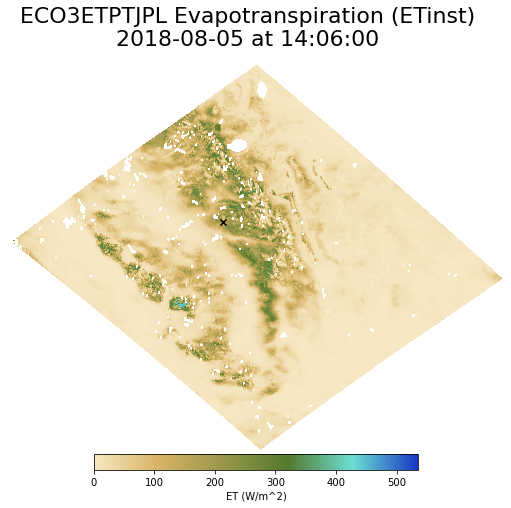

In [32]:
title = 'ECO3ETPTJPL Evapotranspiration'
SDSname = ecoSDS[0].split("/")[-1]
fig = plt.figure(figsize=(9.7,7.6))                                                       # Set the figure size (x,y)
fig.suptitle(f'{title} ({ecoSDS[0].split("/")[-1]})\n{date} at {overpass}', fontsize=22)  # Add title for the plots
plt.axis('off')                                                                           # Remove axes from plot
im = plt.imshow(ETgeo, cmap=ETcmap);                                                        # Plot array using colormap
plt.scatter(Tcol, Trow, color="black", marker='x')                                        # Plot tower location

# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.004, label=f'ET ({units})', shrink=0.6).outline.set_visible(True)

***
## 6d. Exporting an Image
#### Zoom in to get a closer look at the region surrounding the AmeriFlux tower by creating a subset.

In [33]:
# Set a Radius and calculate subset region from flux tower location (row, col)
radius = 1700
ETsubset = ETgeo[(Trow - radius):(Trow + radius + 1), (Tcol - radius):(Tcol + radius + 1)]

#### Make another plot, this time zoomed in to the tower location. Export the plot as a .png file. 

figure filename: D:\Downloads\ecoworkshop\output\ECOSTRESS_L3_ET_PT-JPL_00468_007_20180805T220314_0601_04_ETinst.png


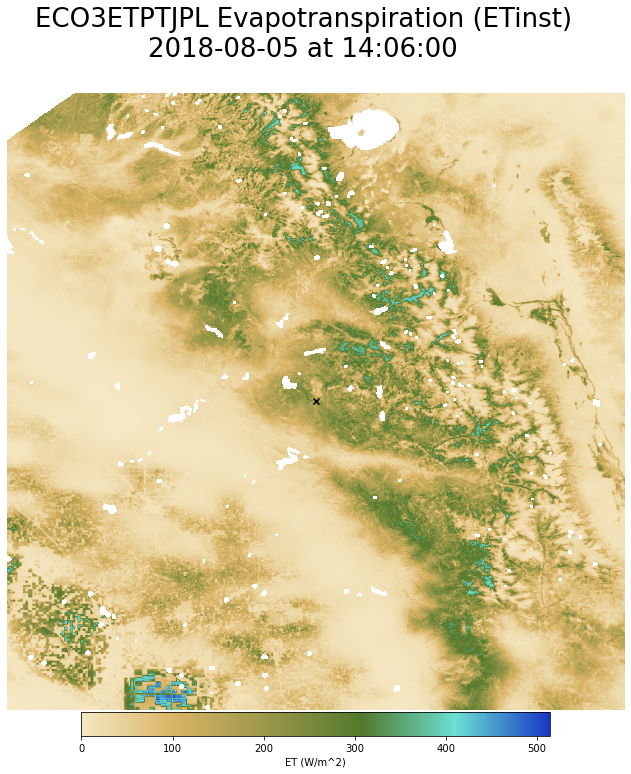

In [34]:
fig = plt.figure(figsize=(14,12))                                                 # Set the figure size (x,y)
fig.suptitle(f'{title} ({SDSname})\n{date} at {overpass}', fontsize=26)           # Add title for the plots
plt.axis('off')                                                                   # Remove axes from plot
im = plt.imshow(ETsubset, cmap=ETcmap);                                             # Plot array using colormap
plt.scatter(ETsubset.shape[0]/2, ETsubset.shape[1]/2, color="black", marker='x')  # Tower is in middle of subset

# Add a colormap legend
plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.004, label=f'ET ({units})', shrink=0.6).outline.set_visible(True)

# Set up file name and export to png file
figure_filename = join(outDir, "{}_{}.png".format(ecoName, SDSname))
print("figure filename: {}".format(figure_filename))
fig.savefig(figure_filename, dpi=300)
plt.show()

***
<h1><center>7. Comparing Observations</center></h1>

***
## 7a. Calculate Distribution of ECOSTRESS Data
#### First, collect a 3x3 grid centered on the flux tower pixel as a subset to calculate statistics on. 

In [35]:
# Subset data to 3x3 grid surrounding flux tower for both layers
ETfootprint = ETgeo[(Trow - 1):(Trow + 2), (Tcol - 1):(Tcol + 2)] 
UNfootprint = UNgeo[(Trow - 1):(Trow + 2), (Tcol - 1):(Tcol + 2)] 
print(ETfootprint)

[[161.3531036376953 161.25172424316406 145.38726806640625]
 [156.7587432861328 172.5819549560547 172.5819549560547]
 [140.9962158203125 140.9962158203125 185.904052734375]]


#### In case the 3x3 grid contains missing values, use `np.nanmedian` to ignoring missing values and calculate the measure of central tendency.

In [36]:
ETmedian = np.nanmedian(ETfootprint)
UNmedian = np.nanmedian(UNfootprint)
print(f"Median ET: {ETmedian:0.3f} \nUncertainty: {UNmedian:0.3f}")

Median ET: 161.252 
Uncertainty: 95.294


#### Next, generate a probability density function for the 3x3 grid of ET values.

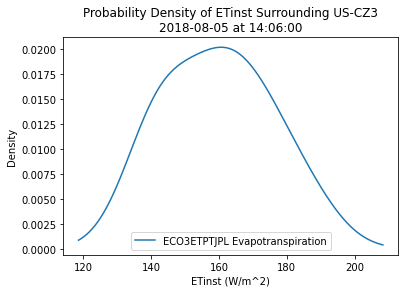

In [37]:
pd.DataFrame({title: ETfootprint.flatten()}).plot.kde()                                   # Pandas Kernel Density Estimate
plt.title(f'Probability Density of {SDSname} Surrounding US-CZ3\n{date} at {overpass}');  # Title
plt.xlabel(f'{SDSname} ({units})');                                                       # X-axis label

***
## 7b. Visualize Ground Observations 

#### Next, examine the series of eddy covariance observations from the AmeriFlux US-CZ3 dataset.

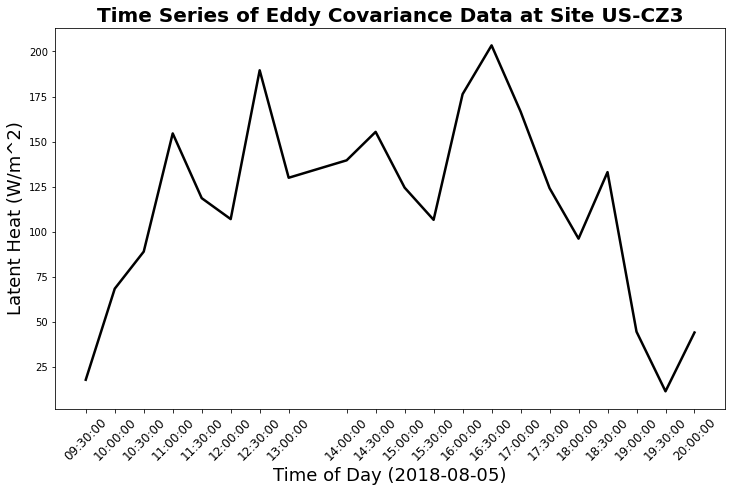

In [38]:
fig = plt.figure(figsize=(12,7))                                                                      # Set fig size (x,y)
ax = fig.add_subplot(111)                                                                             # Create a subplot
ax.plot(towerData['Date/Time'], towerData.LE, 'k', lw=2.5, color='black')                                     # Plot as a black line
ax.set_title(f'Time Series of Eddy Covariance Data at Site US-CZ3', fontsize=20, fontweight='bold');  # Set Title
ax.set_ylabel('Latent Heat (W/m^2)', fontsize=18);                                                    # Y-axis label
ax.set_xlabel(f'Time of Day ({date})', fontsize=18);                                                  # X-axis label
ax.set_xticks(towerData['Date/Time']);                                                              # Set the x ticks
ax.set_xticklabels(towerData['Time'], rotation=45,fontsize=12);                                          # Set x tick labels

#### Above, we can see the daily range in Latent Heat as captured by the eddy covariance observations on the flux tower.

***
## 7c. Combine ECOSTRESS and Ground Observations 

#### Finally, compare the ECOSTRESS Evapotranspiration and uncertainty with the time series of observations from the flux tower.

figure filename: D:\Downloads\ecoworkshop\output\ECOSTRESS_L3_ET_PT-JPL_00468_007_20180805T220314_0601_04_ETinst_vs_fluxtower.png


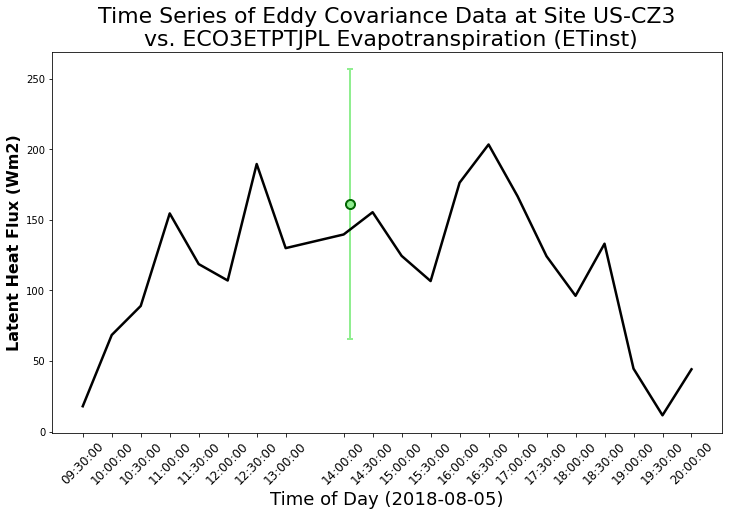

In [39]:
# Set the figure size, create a subplot
fig = plt.figure(1, figsize=(12, 7))
ax = fig.add_subplot(111)

# Plot the flux tower observatisons followed by the ecostress median ET and median uncertainty
ax.plot(towerData['Date/Time'], towerData.LE, 'k', lw=2.5, color='black')
ax.plot(solarOverpass, ETmedian, 'bo', ms=10, color='darkgreen')
ax.errorbar(solarOverpass, ETmedian, yerr=UNmedian, lw=2.0, c='lightgreen', fmt='o', capsize=3, capthick=2)

# Set x/y axes and labels
ax.set_xlabel(f'Time of Day ({date})', fontsize=18);
ax.set_xticks(towerData['Date/Time']);
ax.set_xticklabels(towerData.Time, rotation=45,fontsize=12);
ax.set_ylabel("Latent Heat Flux (Wm2)", fontsize=16, fontweight='bold')

# Add a title and export figure as png file
ax.set_title(f"Time Series of Eddy Covariance Data at Site US-CZ3\n vs. {title} ({SDSname})", fontsize=22)
figure_filename = join(outDir, "{}_{}_vs_fluxtower.png".format(ecoName, SDSname))
print("figure filename: {}".format(figure_filename))
fig.savefig(figure_filename, bbox_inches='tight')

***
## Citations
- Hook, S., Fisher, J. (2019). ECOSTRESS Evapotranspiration PT-JPL Daily L3 Global 70 m V001 [Data set]. NASA EOSDIS Land Processes DAAC. Accessed 2021-03-11 from https://doi.org/10.5067/ECOSTRESS/ECO3ETPTJPL.001. 


- Goulden, M., (2018). AmeriFlux US-CZ3 Sierra Critical Zone, Sierra Transect, Sierran Mixed Conifer, P301, [doi:10.17190/AMF/1419512](http://dx.doi.org/10.17190/AMF/1419512). 


- Krehbiel, C., and Halverson, G.H., (2019). Working with ECOSTRESS Evapotranspiration Data [Jupyter Notebook]. Retrieved from https://git.earthdata.nasa.gov/projects/LPDUR/repos/tutorial-ecostress/browse

***
<div class="alert alert-block alert-info">
<h1> Contact Information </h1> 

<h3> Material written by Cole Krehbiel$^{1}$ and Gregory Halverson$^{2}$ </h3>

<b>Contact:</b> LPDAAC@usgs.gov  

<b>Voice:</b> +1-866-573-3222  

<b>Organization:</b> Land Processes Distributed Active Archive Center (LP DAAC)  

<b>Website:</b> https://lpdaac.usgs.gov/  

<b>Date last modified:</b> 03-11-2021  


$^{1}$Innovate! Inc., contractor to the U.S. Geological Survey, Earth Resources Observation and Science (EROS) Center, Sioux Falls, South Dakota, 57198-001, USA. Work performed under USGS contract G15PD00467 for LP DAAC$^{3}$.

$^{3}$LP DAAC Work performed under NASA contract NNG14HH33I. 

$^{2}$ Jet Propulsion Laboratory, California Institute of Technology, Pasadena, CA, USA